In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from keras.models import Model

## **DEEP LEARNING MODEL**

**Data Preprocessing**


In [ ]:
# loading ratings data from csv
rating = pd.read_csv("/content/ratings.csv", names=["userId","movieId","rating","timestamp"], skiprows=1)
rating = rating.drop('timestamp', axis=1)
# number of users: 610

In [ ]:
movies = pd.read_csv("/content/movies.csv",
                      names=["movieId","title","genres"],
                      skiprows=1)
# number of movies: 9742

In [ ]:
data = pd.merge(rating, movies, on='movieId')
data
# the number of user is unchanged, number of movies is now 9724 becouse not all movies have a review

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...
100831,610,160341,2.5,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,Blair Witch (2016),Horror|Thriller


In [ ]:
from sklearn.preprocessing import LabelEncoder
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

data['user'] = user_encoder.fit_transform(data['userId'])
data['movie'] = pd.Categorical(data['movieId']).codes

In [ ]:
data.head() #visualization of the first 5 row od data

,userId,movieId,rating,title,genres,user,movie
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,0
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,0
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14,0
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,16,0


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
n_movies = data[["movie"]].drop_duplicates().shape[0]
n_users = rating['userId'].unique().shape[0]
print(n_movies, n_users)

9724 610


**Model Architecture**

In [ ]:
# creating movies embedding path
movies_input = Input(shape=[1], name="Movies-Input")
movies_embedding = Embedding(n_movies+1, 5, name="Movies-Embedding")(movies_input)
movies_vec = Flatten(name="Flatten-Movies")(movies_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([movies_vec, user_vec])

# add fully-connected-layers
dropout0 = Dropout(0.2)(conc)
fc1 = Dense(32, activation='relu')(dropout0)
dropout1 = Dropout(0.2)(fc1)
fc2 = Dense(16, activation='relu')(dropout1)
out = Dense(1)(fc2)

# Create model and compile it
model = Model([user_input, movies_input], out)
model.compile('adam', 'mean_squared_error')

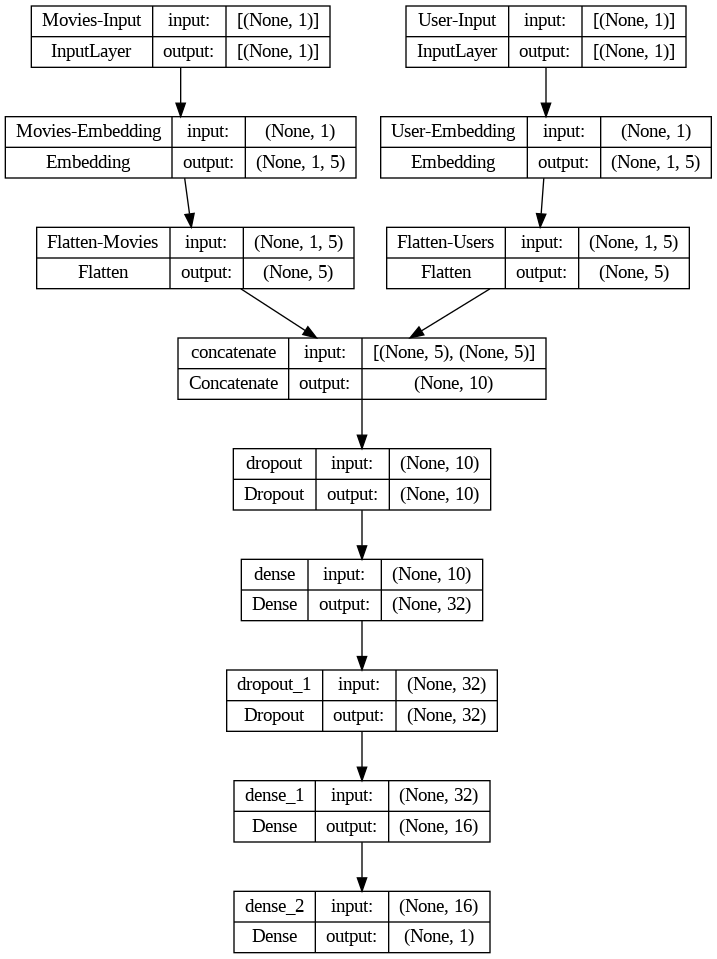

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

**Training**

In [ ]:
history = model.fit([train['user'], train['movie']], train['rating'], epochs=10, batch_size=8)

Epoch 1/10
10084/10084 [==============================] - 37s 3ms/step - loss: 0.9752
Epoch 2/10
10084/10084 [==============================] - 30s 3ms/step - loss: 0.7595
Epoch 3/10
10084/10084 [==============================] - 26s 3ms/step - loss: 0.7252
Epoch 4/10
10084/10084 [==============================] - 35s 3ms/step - loss: 0.7027
Epoch 5/10
10084/10084 [==============================] - 29s 3ms/step - loss: 0.6912
Epoch 6/10
10084/10084 [==============================] - 22s 2ms/step - loss: 0.6841
Epoch 7/10
10084/10084 [==============================] - 25s 2ms/step - loss: 0.6776
Epoch 8/10
10084/10084 [==============================] - 26s 3ms/step - loss: 0.6710
Epoch 9/10
10084/10084 [==============================] - 26s 3ms/step - loss: 0.6658
Epoch 10/10
10084/10084 [==============================] - 24s 2ms/step - loss: 0.6623


Text(0, 0.5, 'Training Error')

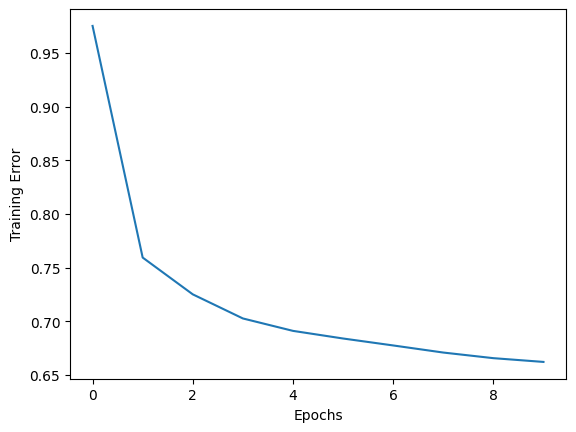

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

**Test and evaluation**

In [ ]:
model.evaluate([test["user"], test["movie"]], test["rating"])

631/631 [==============================] - 1s 2ms/step - loss: 0.7387


0.7386579513549805

In [ ]:
# creation of input for prediction
movies_data = np.array(list(set(data.movie)))

# id of the user that we want to see the prediction
id_user = 1
user = np.array([id_user for i in range(len(movies_data))])

predictions = model.predict([user, movies_data])

304/304 [==============================] - 1s 4ms/step


In [ ]:
predictions = np.array([a[0] for a in predictions])

In [ ]:
# additional function to calculate the number of OUTLIERS
recommended_movies_ids = (-predictions).argsort()
j = 0 # outliers < than 0.3
k = 0 # outliers > than 5.2
for i in range(0, len(recommended_movies_ids)-1):
  if (predictions[i] < 0.3):
    j += 1
    print(predictions[i])
  if (predictions[i] > 5.2):
    k += 1
print(j, k, " sum:", j+k)

0 0  sum: 0


In [ ]:
# method in which I display all the movies reviewed by a user and the model's prediction of those movies

j = 0 # j counts the number of review
for i in range(data.shape[0]):
  if (id_user == data['user'][i]):
    print(data['movie'].iloc[i], " ", data['title'].iloc[i], "-",
          data['genres'].iloc[i], data['rating'].iloc[i], " vs ", predictions[data['movie'].iloc[i]])
    j += 1
j

291   Tommy Boy (1995) - Comedy 4.0  vs  3.4580247
2670   Gladiator (2000) - Action|Adventure|Drama 4.0  vs  3.739492
277   Shawshank Redemption, The (1994) - Crime|Drama 3.0  vs  4.2798367
1283   Good Will Hunting (1997) - Drama|Romance 4.5  vs  3.902498
4607   Kill Bill: Vol. 1 (2003) - Action|Crime|Thriller 4.0  vs  4.1076355
5294   Collateral (2004) - Action|Crime|Drama|Thriller 3.5  vs  3.596042
6236   Talladega Nights: The Ballad of Ricky Bobby (2006) - Action|Comedy 4.0  vs  3.2601266
6298   Departed, The (2006) - Crime|Drama|Thriller 4.0  vs  4.237342
6693   Dark Knight, The (2008) - Action|Crime|Drama|IMAX 4.5  vs  4.2049837
6784   Step Brothers (2008) - Comedy 5.0  vs  3.3592384
6993   Inglourious Basterds (2009) - Action|Drama|War 4.5  vs  4.0486937
7137   Zombieland (2009) - Action|Comedy|Horror 3.0  vs  3.7374275
7241   Shutter Island (2010) - Drama|Mystery|Thriller 4.0  vs  3.8716848
7306   Exit Through the Gift Shop (2010) - Comedy|Documentary 3.0  vs  4.1298923
7355   I

29

In [ ]:
recommended_movies_ids = (-predictions).argsort()[:10]

print(recommended_movies_ids)

predictions[recommended_movies_ids]

[1761 2579  277 6298 2409  898 8237  659  796 6693]


array([4.3644886, 4.302701 , 4.2798367, 4.237342 , 4.2274113, 4.224248 ,
       4.2237816, 4.212536 , 4.2081876, 4.2049837], dtype=float32)

In [ ]:
film = data[["movie", "movieId","title","genres"]].sort_values(by='movie').drop_duplicates()
film = film.set_index('movie')

# prediction for the user
# i : movie index (range from 0 to 9723)
# j : order of preference (from 0 being the most recommended to 9 being the 10 recommended movies )
for i in range(predictions.shape[0]) :
  for j in range(recommended_movies_ids.shape[0]) :
    if (i == recommended_movies_ids[j]) :
      print(i,j,film['title'].iloc[i],"-", film['genres'].iloc[i], predictions[i])

277 2 Shawshank Redemption, The (1994) - Crime|Drama 4.2798367
659 7 Godfather, The (1972) - Crime|Drama 4.212536
796 8 Secrets & Lies (1996) - Drama 4.2081876
898 5 Princess Bride, The (1987) - Action|Adventure|Comedy|Fantasy|Romance 4.224248
1761 0 Celebration, The (Festen) (1998) - Drama 4.3644886
2409 4 Five Easy Pieces (1970) - Drama 4.2274113
2579 1 Guess Who's Coming to Dinner (1967) - Drama 4.302701
6298 3 Departed, The (2006) - Crime|Drama|Thriller 4.237342
6693 9 Dark Knight, The (2008) - Action|Crime|Drama|IMAX 4.2049837
8237 6 Prisoners (2013) - Drama|Mystery|Thriller 4.2237816


## **TRADITIONAL MODEL, MATRIX FACTORIZATION**

In [ ]:
class Matrix_Factorization:
    def __init__(self, alpha = 0.00001, iterations = 50, num_of_latent = 200, lam = 0.0005):
        self.alpha = alpha
        self.iterations = iterations
        self.num_of_latent = num_of_latent
        self.lam = lam

    def fit(self, train):
        num_user = max([t[0] for t in train]) + 1
        num_movie = max([t[1] for t in train]) + 1

        self.train = train

        # P represents the user matrix, and Q represents the movie matrix
        self.P = np.random.normal(0, 1, (num_user, self.num_of_latent))
        self.Q = np.random.normal(0, 1, (num_movie, self.num_of_latent))

        rmse_lst = []
        for f in range(self.iterations):
            np.random.shuffle(self.train)

            temp_mse = 0
            previous_Q = np.copy(self.Q)
            previous_P = np.copy(self.P)
            Count = 0

            for tup in self.train:
                u,i,rating = tup
                error = rating - self.Q[i].T @ self.P[u]

                if abs(error) > 20:
                    continue
                Count += 1
                temp_mse += error**2

                self.P[u] += 2 * self.alpha * error * self.Q[i] - self.lam * self.P[u]
                self.Q[i] += 2 * self.alpha * error * self.P[u] - self.lam * self.Q[i]

            rmse_lst.append(np.sqrt(temp_mse/Count))
            print(np.sqrt(temp_mse/Count))

            if len(rmse_lst) > 1 and rmse_lst[-1] < rmse_lst[-2]:
                self.alpha *= np.random.uniform(1, 1.5)
            else:
                self.alpha /= np.random.uniform(1, 1.5)
                if len(rmse_lst) > 1 and (rmse_lst[-2] - rmse_lst[-1]) / rmse_lst[-2] > 0.1:
                    self.Q = previous_Q
                    self.P = previous_P

        self.rmse = rmse_lst

    def ind_predict(self, tup):
        u,i,_ = tup
        return self.Q[i].T @ self.P[u]

    def predict(self, X):
        res = []
        for i in X:
            res.append(self.ind_predict(i))
        return res

In [ ]:
class Matrix_Factorization:
    def __init__(self, alpha = 0.00001, iterations = 50, num_of_latent = 200, lam = 0.0005):
        """
            Some initializations, if neccesary

            attributes:
                        alpha: Learning Rate, default 0.01
                        num_iter: Number of Iterations to update coefficient with training data
                        num_of_latent: Number of latent factor.
                        lam: Regularization constant


            TODO: 1. Initialize all variables needed.
        """
        self.alpha = alpha
        self.iterations = iterations
        self.num_of_latent = num_of_latent
        self.lam = lam

    def fit(self, train):
        """
            Train: list of tuples with (User, Movie, Rating)
            num_user: Number of unique user.
            num_movie: Number of unique movie

            TODO: 2. Initialize num_user and num_movie
                  3. Save the training set.
                  4. Initialize P and Q matrix, with normal distribution with mean = 0.
                  Hint: Think about what P and Q represent, what they should do.Think about the shape too.


        """
        num_user = max([t[0] for t in train]) + 1
        num_movie = max([t[1] for t in train]) + 1

        self.train = train

        # P represents the user matrix, and Q represents the movie matrix
        self.P = np.random.normal(0, 1, (num_user, self.num_of_latent))
        self.Q = np.random.normal(0, 1, (num_movie, self.num_of_latent))

        rmse_lst = []

        """
            TODO: 5: Calculate the error, using P and Q matrix.
                  6: We need to check if the absolute value error is less than some constant. Store the previous Q and P for adaptive learning rate.
                      If it is less than that constant then we update P and Q matrix.
                      (When update, update the P and Q at the same time. Think about why it is important.)
                      Otherwise use the error to update the Q and P matrix.

                  7: For each entry update temp_mse, and append the Current iteration RMSE to rmse_lst.

        """

        for f in range(self.iterations):
            ### Random Shuffle. Why is this called?
            np.random.shuffle(self.train)

            temp_mse = 0
            previous_Q = np.copy(self.Q)
            previous_P = np.copy(self.P)
            Count = 0

            for tup in self.train:
                u,i,rating = tup
                error = rating - self.Q[i].T @ self.P[u]

                if abs(error) > 20:
                    continue
                Count += 1
                temp_mse += error**2

                self.P[u] += 2 * self.alpha * error * self.Q[i] - self.lam * self.P[u]
                self.Q[i] += 2 * self.alpha * error * self.P[u] - self.lam * self.Q[i]

            rmse_lst.append(np.sqrt(temp_mse/Count))
            print(np.sqrt(temp_mse/Count))


            """
                TODO: 8: Implement the adaptive learning rate.
                         If current rmse is less than previous iteration, let's increase by a factor range from 1 - 1.5
                         Otherwise we decrease by a factor range from 0.5 - 1
                      9: If the current rmse is greater than previous iteration.
                         Check the relative error, (previous - current)/ previous.
                         If it is greater than 0.1, we restore the previous Q and P. (Try without it. Think about why we need this.)
            """
            if len(rmse_lst) > 1 and rmse_lst[-1] < rmse_lst[-2]:
                self.alpha *= np.random.uniform(1, 1.5)
            else:
                self.alpha /= np.random.uniform(1, 1.5)
                if len(rmse_lst) > 1 and (rmse_lst[-2] - rmse_lst[-1]) / rmse_lst[-2] > 0.1:
                    self.Q = previous_Q
                    self.P = previous_P

        self.rmse = rmse_lst

    def ind_predict(self, tup):
        """
            tup: One single entry, (user, movie)

            TODO: 10: Use P and Q to make prediction on single entry.

        """
        u,i,_ = tup
        return self.Q[i].T @ self.P[u]

    def predict(self, X):
        """
            X: list of entries

            TODO: 11: Use ind_predict we create to make predicitons.
        """
        res = []
        for i in X:
            res.append(self.ind_predict(i))
        return res

In [ ]:
class Matrix_Factorization_with_bias:
    def __init__(self, alpha = 0.00001, iterations = 50, num_of_latent = 200, lam = 0.01):
        self.alpha = alpha
        self.iterations = iterations
        self.num_of_latent = num_of_latent
        self.lam = lam


    def fit(self, train):
        num_user = max([t[0] for t in train]) + 1
        num_movie = max([t[1] for t in train]) + 1

        self.train = train

        self.P = np.random.normal(0, 1, (num_user, self.num_of_latent))
        self.Q = np.random.normal(0, 1, (num_movie, self.num_of_latent))

        self.bu = np.random.uniform(size=num_user)
        self.bi = np.random.uniform(size=num_movie)
        self.b = np.mean(list(map(lambda t:t[2], train)))

        rmse_lst = []

        for f in range(self.iterations):
            np.random.shuffle(self.train)

            temp_mse = 0
            previous_Q = self.Q.copy()
            previous_P = self.P.copy()
            previous_bu = self.bu.copy()
            previous_bi = self.bi.copy()

            Count = 0
            for tup in self.train:
                u,i,rating = tup

                error = rating - self.Q[i].T @ self.P[u] - self.bu[u] - self.bi[i] - self.b
                Count += 1
                temp_mse += error ** 2

                p = self.P[u].copy()
                self.P[u] += 2 * self.alpha * error * self.Q[i] - self.lam * self.P[u]
                self.Q[i] += 2 * self.alpha * error * p - self.lam * self.Q[i]

                self.bu[u] += 2 * self.alpha * error - self.lam * self.bu[u]
                self.bi[i] += 2 * self.alpha * error - self.lam * self.bi[i]

            rmse_lst.append(np.sqrt(temp_mse/Count))
            print(np.sqrt(temp_mse/Count))

            if len(rmse_lst) > 1 and rmse_lst[-1] < rmse_lst[-2]:
                self.alpha *= np.random.uniform(1, 1.5)
            else:
                self.alpha /= np.random.uniform(1, 1.5)
                if len(rmse_lst) > 1 and (rmse_lst[-2] - rmse_lst[-1]) / rmse_lst[-2] > 0.1:
                    self.Q = previous_Q
                    self.P = previous_P
                    self.bu = previous_bu
                    self.bi = previous_bi

        self.rmse = rmse_lst

    def ind_predict(self, tup):
        u,i,_ = tup
        return self.Q[i].T @ self.P[u] + self.bu[u] + self.bi[i] + self.b


    def predict(self, X):
        res = []
        for i in X:
            res.append(self.ind_predict(i))
        return res


**Data preprocessing**


in this case the preprocessing is slightly different because the model requires input in a different format

In [ ]:
ratings = pd.read_csv('./ratings.csv')
ratings = ratings.sort_values('timestamp').reset_index(drop = True).astype(int)
a = np.sort(ratings.movieId.unique())
index_dict = {}
for i in range(len(a)):
    index_dict[a[i]]  = i
ratings.movieId = ratings.movieId.apply(lambda x: index_dict[x])

grouped_userId = list(ratings.groupby(['userId']).apply(lambda x: x[['movieId','rating']].values))
grouped_movieId = list(ratings.groupby(['movieId']).apply(lambda x: x[['userId','rating']].values))

In [ ]:
np.random.seed(0)
train = set()
test = set()

for i in range(len(grouped_movieId)):
    temp_len = len(grouped_movieId[i])
    for j in range(temp_len):
        if j < temp_len * 0.8:
            train.add((grouped_movieId[i][j][0]-1,i - 1, grouped_movieId[i][j][1]))
        else:
            test.add((grouped_movieId[i][j][0] -1, i - 1,grouped_movieId[i][j][1]))
train = list(train)
test = list(test)

**Training and Test**

In [ ]:
clf = Matrix_Factorization_with_bias(alpha = 5e-4, iterations = 20, num_of_latent = 5, lam = 6e-3)
clf.fit(train)

1.6924172060116782
1.2434957294952644
1.1648729311711619
1.1249885210063242
1.0978498677917472
1.070940298545258
1.0468986162133067
1.025245229870934
1.000155698513702
0.9762249478949396
0.9541863049756328
0.934335315981032
0.9180329377570957
0.9056281068065704
0.8962547814634203
0.8903519444484931
0.8861985734915271
0.8797690662657304
0.8794244456386895
0.8672528338430767


In [ ]:
error = 0
pred = clf.predict(test)
for i in range(len(test)):
    error += (test[i][2] - pred[i])**2

In [ ]:
# MSE
(error/ len(test))** (0.5)

0.9796998792776033